# An introduction to the Seats-Votes Curve

*Levi John Wolf<br>
University of Bristol<br>
levi.john.wolf@gmail.com<br>
(Supported by NSF #1657689)*

# The History of the Seats-Votes Curve

The "seats votes curve," a theoretical model describing how many seats a party wins in the legislature as a function of their popular vote percentage, is a long-lived concept in Political Science. Early work studying the British electoral system focused on the ["Cube Rule,"](https://en.wikipedia.org/wiki/Cube_rule), a theory describing how winners tend to be *overrepresented* in legislatures in two-party, first-past-the-post electoral systems like that found in the US, New Zealand, or the UK. While originally formulated in the early 20th century, empirical study of the law continued in earnest until around the 1970s. There, studies by Kendall (1950), Taagepara (1973), and Tufte (1973) discuss the relationship in terms of a *long-run* historical relationship. For them, the seats-votes curve is an *empirical description of the relationship between the vote share a party won and the percentage of the legislature that the party ended up winning.* Thus, much of the early work on *structural analysis* of electoral systems focused on the detection of empirical regularities. 

Later work after Browning (1987) or Gelman (1994) moved to a much stronger inferential framework in order to try to estimate this relationship *within individual elections*. Much of the recent academic work on partisan gerrymandering comes in this mode of analysis. For example, nearly all of the entries in the [**Common Cause Gerrymandering Writing Competition**](https://www.commoncause.org/partisan-gerrymandering-writing-competition/) were in this mode of analysis, and many of the political models used by "ensemble" analyses following Chen & Rodden (2013) follow this approach. 

In hopes of providing some groundwork in electoral sciences, I'll cover a little bit about the historical method of analysis before we move to the within-election analysis that's more common today. I'll talk about the logic of the model, possible pitfalls with its interpretation and representation of elections. This work is built in Python, on top of the `seatsvotes` library, a new library for working with Electoral Data, like `pscl` in R. 

First, though, let's pull in some required packages for our analysis. The `import` statement in Python is kind of like the `library()` statement in `R`, except that in Python we always refer to the package explicitly when we use a function from that package (like you might if you used `dplyr::mutate()` instead of just `mutate()`). 

In [1]:
import pandas
import numpy
import seaborn
import seatsvotes
import matplotlib.pyplot as plt
%matplotlib inline

/home/lw17329/anaconda/envs/ana/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lw17329/anaconda/envs/ana/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


The `seatsvotes` package is a new package developed as part of NSF 1657689, and wraps up a couple of previous methods for modelling seats-votes curves (like Gelman & King (1994), Linzer (2013), an adaptation of McGann et al. (2014)) and a few new methods. It also ships with it much of the example data that is used in common explorations of electoral bias.

So, to start our exploration, let's first load in the example dataset provided for historical elections to the US Congress from 1896 to 2010. This is a subset of the data available from the [**Spatiotemporal Database of Congressional Elections**](https://www.nature.com/articles/sdata2017108). Since we're not working with the spatial data, we'll primarily be using the results that bridge the original ICSPR 6311 and later products from the Consitituency Level Electoral Archive. 

In [10]:
house = seatsvotes.data.congress()

In [11]:
house.head()

,year,idx,state,dist,inc,vote_share,turnout,south
0,1896,1,1,1,NaN,0.282184,38482.0,0
1,1896,2,1,2,NaN,0.383052,58261.0,0
2,1896,3,1,3,NaN,0.334220,22934.0,0
3,1896,4,1,4,NaN,0.338997,46381.0,0
4,1896,5,2,1,NaN,0.312600,28119.0,0


By convention, we usually model Democrats as the "Reference party," but this can be flipped and the analyses simply flip as well.

# The finnicky nature of averages

Early on, work in this literature was fairly consistently concerned with the distinction between *party vote share* and *average district vote share*. Subtly, this distinction arises because the average of each districts' vote shares *is not* equal to the percent of all votes the party receives. Basically, if we let 
- $v_i$ be the number of votes cast for Democrats in district $i$
- $n_i$ be the total number of votes cast in district $i$
- $k$ be the number of districts in the electoral system,

this concern arises because the "total" popular vote percentage for a party is not equal to its average vote share among districts; since districts have different turnouts, the two aren't equal in general:
$$ \frac{\sum_{i}^k v_i}{\sum_{i}^k n_i} \neq \frac{1}{k} \sum_i^k \frac{v_i}{n_i}$$

Or really simply, say we have two districts, one with 4 voters and the other with 6 voters. Let's say the smaller district has 3 Democrat voters and the larger district has 3 as well. Then, we can see this ineqality in action: 

In [19]:
(3+3)/(4 + 6) # The popular vote for Dems

0.6

In [21]:
((3/4) + (3/6))/2 # The average district vote for Dems

0.625

Practically speaking, this does not pose serious challenges to an analysis, so long as we recognize that the two are distinct conceptually and have different practical implications. In general, again, modern scholarship tends to focus on the mean district vote share because it's simpler to model, and tends to have more actionable impacts for practical models of elections. However, as Johnston (1983) discusses, this distinction can have a big impact when discussing the power of changes in vote share in specific districts. 

I'll illustrate the difference systematically below, but we'll need to keep this in mind later when discussing how seats-votes relationships may show *asymmetry* or *bias* for one party over another. 

In [22]:
house['dem_votes'] = house.vote_share * house.turnout

Since we're working in Pandas, we can build up each years' average district voteshare *as well as* the the party voteshare in each year. I'll do this to show the discrepancy that occurs in the relationship (since it's often structurally-relevant).

First we group:

In [23]:
grouper = house.groupby('year')

Then, get the total Dem votes in each year divided by the total turnout that year to get the *party voteshare*, or the popular vote for Dems:

In [25]:
party_voteshare = grouper.dem_votes.sum() / grouper.turnout.sum()

Then, we can use the `.mean()` method directly to get the mean of district voteshares:

In [26]:
party_average_voteshare = grouper.vote_share.mean()

Finally, while it can sometimes be flawed in multi-party elections, we'll rely on the fact that this data is *two party vote* data, not raw elections data. This means that we're only considering votes cast for one of the two main parties; all of the rest of the votes are discarded in this analysis. With this in mind, we can find whether or not the Democrat candidate won in the district by looking at whether or not the district's vote share for Democrats is more than 50%. In two-party vote share data, this means that the Democratic vote share is larger than the Republican vote share, regardless of if *neither of them* win an outright majority. 

In [27]:
party_seatshare = grouper.apply(lambda x: (x.vote_share > .5).mean())

Now, we have the party's popular vote (or party voteshare) in each election to Congress since 1896, we have the average district vote too, and we have the fraction of the congress Dems won that year.

Then, we can see the way the average district vote (or the popular voteshare) are related to the fraction of Congress Dems win by making a scatterplot of all the years together:

Text(0,0.5,'% Seats won by Dems')

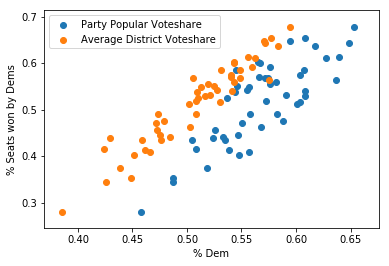

In [28]:
plt.scatter(party_average_voteshare, party_seatshare, 
            label='Party Popular Voteshare')
plt.scatter(party_voteshare, party_seatshare, 
            label='Average District Voteshare')
plt.legend()
plt.xlabel("% Dem")
plt.ylabel("% Seats won by Dems")

Note that, in general, the average district voteshare is *smaller than* the party popular voteshare. *talk about McDonald and the way turnout and vote choice interact from Linzer*. 

# The classic seats-votes model

Actually fit the Tufte/tageparga model